In [1]:
import pandas as pd
import numpy as np


from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,Imputer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin,RegressorMixin


from skrvm import RVR
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import random

from joblib import Parallel, delayed

parent_folder = '/Volumes/phelpslab2/Emily/gsp/'
input_data_folder = parent_folder + 'processed_data_for_models/'
output_data_folder = parent_folder + 'python_modeling_output/'

### functions from anx_pred_modeling.ipynb

In [2]:
def cv_stratified(n_folds,y):
    #creates stratified cross validation folds (for k-fold cv) using continuous target variable (y) 
    #Args:
        #n_folds, number of folds for cv
        #y, the target variable
    #Returns:
        #CViterator, iterable of length n_folds that can be used with gridsearchcv
    idx = np.argsort(y,0)
    n = len(y)
    all_idx = np.arange(n)

    CViterator = []
    for k in range(n_folds):
        test_idx = idx[np.arange(k,n,n_folds)].ravel()
        test_bool = np.zeros(n,dtype=bool)
        test_bool[test_idx]=True
        train_bool= ~test_bool
        train_idx = all_idx[train_bool]

        CViterator.append((train_idx,test_idx))
    return(CViterator)
    

In [3]:
def nested_cv(X,y,estimator,param_grid):
    #performs nested cv (6 fold for inner and outer) for selecting hyperparameters
    #Args:
        #X, np array of features (n x n_features) or list (length n) of  timecourse nparrays for nilearn
        #y, the target variable
        #estimator, sklearn estimator
        #param_grid, list of hyperparameter values
    #Returns:
        #r2, r2 score
        #preds, predictions of model (in same order as y)
        #param_selected, hyperparameter value that was chosen.
    n_folds = 6
    outer_cv = cv_stratified(n_folds,y)

    param_selected = []
    preds = np.zeros(np.shape(y))
    
    for train, test in outer_cv:
        inner_cv = cv_stratified(n_folds,y[train])
        if type(X)==list: #this allows for tangent matrix approach via nilearn
            X_train = [X[i] for i in train]
            X_test = [X[i] for i in test]
        else:
            X_train = X[train]
            X_test = X[test]
  
        reg_inner= GridSearchCV(estimator=estimator, param_grid=param_grid, cv=inner_cv, scoring='r2')  
        
        reg_inner.fit(X_train, y[train])
        param_selected.append(reg_inner.best_params_)
        preds[test] = reg_inner.best_estimator_.predict(X_test)

        r2 = r2_score(y,preds)
    return(r2,preds,param_selected)



In [4]:
def stack(Xs,y,inner_pipeline,outer_pipeline):
    #performs model stacking for different X datasets, eg, rfMRI data and structural data
    #does not do hyperparameter selection
    #Args:
        #Xs is a list containing the features for different datasets. elements should be n x n_feat np arrays
        #y: target variable, length n
        #inner pipeline: pipeline containing inner (base) model
        #outer_pipeline: pipeline containing outer (stacking) model
    #Output:
        #r2, r squared of stacked model averaged over cv folds
        #preds,  model predictions
    
    n_folds = 6#folds for outer cv for model evaluation
    outer_cv = cv_stratified(n_folds,y) #splits for outer cv for model evaluation
    preds = np.zeros(np.shape(y))
    num_models = len(Xs)
    for train, test in outer_cv:
        y_train_outer = y[train]
        y_test_outer = y[test]
        stack_split = cv_stratified(num_models,y_train_outer)#split into folds for model stacking
        
        #'meta' features (training)--model predictions for dif data sources, (for training examples of outer 
        #cv. calculated on each inner test fold):
        meta_feat_train = np.zeros((len(y_train_outer),num_models))
        # 'meta' features (testing)--model predictions, (for test examples of outer cv. 
        #for each data source, for each inner fold of stacking, get data source predictions for each test example.
        # so 3d array-- n outer test subs x n base models x n inner folds. and here n inner folds = n base models):
        meta_feat_test = np.zeros((len(y_test_outer),num_models,num_models))
        for m in np.arange(num_models): #have to run each model
            X = Xs[m]#select the relevant x dataset
            X_train_outer = X[train] #training examples for outer cv (for model evaluation)
            X_test_outer = X[test]
            #if doing confound regressor, reset X matrix in ConfoundRegressor step:
            if 'conf_reg' in inner_pipeline.named_steps.keys():
                steps_new = inner_pipeline.named_steps
                steps_new['conf_reg'] = ConfoundRegressor(inner_pipeline.named_steps['conf_reg'].confound,X)
                steps_new = [(k,v) for k,v in steps_new.items()]
                inner_pipeline = Pipeline(steps_new)
            for f in np.arange(num_models): #run each inner fold of stacking 

                X_train_inner = X_train_outer[stack_split[f][0]] # training examples for inner stacking fold
                X_test_inner = X_train_outer[stack_split[f][1]]

                y_train_inner = y_train_outer[stack_split[f][0]] 
                y_test_inner = y_train_outer[stack_split[f][1]]

                #fit inner model
                inner_pipeline.fit(X_train_inner, y_train_inner)
                #record predictions for inner and outer test data (meta features)
                meta_feat_train[stack_split[f][1],m] = inner_pipeline.predict(X_test_inner).ravel()
                meta_feat_test[:,m,f] = inner_pipeline.predict(X_test_outer).ravel()
                

        #average test meta features across inner folds
        mean_meta_feat_test = np.mean(meta_feat_test,axis = 2)


        outer_pipeline.fit(meta_feat_train,y=y_train_outer)
        preds[test] = outer_pipeline.predict(mean_meta_feat_test)

    r2 = r2_score(y,preds)
    return(r2,preds)






In [5]:
def stack_perm(Xs_actual,y_actual,inner_pipeline,outer_pipeline,n_iter,figname=None):
    #permutation test of stacking model, with nested cv r squared as evaluation metric. parallelized via joblib
    #X values are shuffled so that X and y no longer correspond to each other. stack function is called and 
    #resulting r squared value is recorded
    #Args:
        #Xs_actual: list of original X nparrays 
        #y_actual: original target variable
        #inner pipeline: pipeline for inner/base models
        #outer_pipeline: pipeline for outer/stacking model
        #n_iter: num iterations for perm test
        #fig_name: string or None. If None, no figure made. otherwise, figure saved with string as name
    #Returns:
        #null_scores: list of  r squared values from null models
        #p: p value for perm test
        #actual score: r2 value for model with unshuffled data
    actual_score,_ = stack(Xs_actual,y_actual,inner_pipeline,outer_pipeline)
    null_scores = np.zeros(n_iter)
    null_scores = Parallel(n_jobs=4)(delayed(one_perm_stack)(
        Xs_actual,y_actual,inner_pipeline,  outer_pipeline) 
                                     for i in range(n_iter))
    null_scores = np.array(null_scores)
    x_min = np.amin(np.append(null_scores,actual_score))-.05
    x_max = np.amax(np.append(null_scores,actual_score))+.05
    y_max = n_iter/3
    
    conf95 = np.percentile(null_scores, 95)
    
    #determine p value:
    num_less = len(null_scores[np.where(null_scores<actual_score)])
    p = 1- np.float(num_less/n_iter)
    
    plt.hist(null_scores,color='grey')
    plt.plot([actual_score,actual_score],[0,y_max],'r')
    plt.plot([conf95,conf95],[0,y_max],'k--')
    plt.legend(['actual r squared','95% conf int'])
    plt.axis([x_min,x_max,0,y_max])
    plt.xlabel('r squared')
    plt.ylabel('num iterations')
    fontsize=15
    plt.rc('font',**{ 'size':fontsize})
    plt.tight_layout()
    if figname:
        plt.savefig(figname)
    return(null_scores,p,actual_score)

In [6]:
def one_perm_stack(Xs_actual,y_actual,inner_pipeline, outer_pipeline):
    #runs one permutation for perm_stack
    shuff_order = np.arange(len(y_actual))
    random.shuffle(shuff_order)
    Xs_shuffled = []
    for i in np.arange(len(Xs_actual)):
        Xs_shuffled.append(Xs_actual[i][shuff_order])
    null_score,_ = stack(Xs_shuffled,y_actual,inner_pipeline,outer_pipeline)
    return(null_score)

In [7]:
class CPM(BaseEstimator, RegressorMixin):
    """ connectome predictive model"""
    #based off of Shen et al  2017, finn et al 2015, Rosenberg et al 2016
    #(referred to as "connectome-based predictive modeling" in Rosenberg et al 2017)
    #selects features that are tightly correlated with y, sum up correlation strengths of these features for each 
    #subject to get "score"
    #perform linear regression using this score as predictor of y
    
    #separate models should be run for positive and negative networks (edges that positively and negatively correlate 
    #with y)
    
    #args: 
        #network, string, can be 'pos' or 'neg'
        #pthresh, threshold for selecting features, default .01
    
    def __init__(self, network='pos',p_thresh=.01):
        if network != 'pos' and network != 'neg':
            raise ValueError("network must be 'pos' or 'neg'")
        if p_thresh <0 or p_thresh >1:
            raise ValueError("invalid p thresh")
        self.p_thresh = p_thresh
        self.network = network #positive or negative network model

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        r = np.zeros(num_ftrs)
        p = np.zeros(num_ftrs)
        self.mask = np.zeros(num_ftrs)
        for i in range(num_ftrs):
            r[i],p[i] = stats.pearsonr(X[:,i],y.ravel())
        
        if self.network=='pos':
            self.mask[(r>0)&(p<self.p_thresh)] = 1
        else:
            self.mask[(r<0)&(p<self.p_thresh)] = 1
        
        X_masked = self.mask*X    
        corr_sum = np.sum(X_masked,axis=1).reshape(n,1)
        predictors = np.concatenate((np.ones((n,1)),corr_sum),axis=1)
        self.beta_ = np.matmul(np.linalg.inv(np.matmul(np.transpose(predictors),predictors)),
                                np.dot(np.transpose(predictors),y))
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "beta_")
        except AttributeError:
            raise RuntimeError("You must train model before predicting!")
        n, num_ftrs = X.shape
        X_masked = self.mask*X  
        corr_sum = np.sum(X_masked,axis=1).reshape(n,1)
    
        predictors = np.concatenate((np.ones((n,1)),corr_sum),axis=1)
        predictions = np.matmul(predictors, self.beta_)
        return predictions 

    def score(self, X, y):
        # r2
        try:
            getattr(self, "beta_")
        except AttributeError:
            raise RuntimeError("You must train model before scoring!")
        predictions = self.predict(X)
        return r2_score(y,predictions)




In [8]:
def cpm_cv(X,y):
    #performs 6 fold cv for cpm model. actually creates/evaluates 2 models, for pos and neg network
    #args:
        #X, np array, predictors
        #y: target  variable
    #returns:
        #r2_pos:  cross validated r squared for powitive network
        #r2_neg:  cross validated r squared for negative network
        #preds_pos: predictions for positive netowrk model
        #preds_neg: predictions for negative network model
    n_folds = 6
    outer_cv = cv_stratified(n_folds,y)

    preds_pos = np.zeros(np.shape(y))
    preds_neg = np.zeros(np.shape(y))

    
    for train, test in outer_cv:
        inner_cv = cv_stratified(n_folds,y[train])
        cpm_pos = CPM(network='pos')
        cpm_pos.fit(X[train],y[train])

        cpm_neg = CPM(network='neg')
        cpm_neg.fit(X[train],y[train])

        preds_pos[test] = cpm_pos.predict(X[test])
        preds_neg[test] = cpm_neg.predict(X[test])

    r2_pos = r2_score(y,preds_pos)
    r2_neg = r2_score(y,preds_neg)
    return(r2_pos,r2_neg,preds_pos,preds_neg)

### load data

In [9]:
#load anx data

compos_anx_file = input_data_folder + 'discovery/composAnxDisc.csv'
anx_data = pd.read_csv(compos_anx_file, header=None)
anx_data = anx_data.values

In [10]:
#load region to region connectivity data
graph_data_file = input_data_folder + 'discovery/fsDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)



In [11]:
#load voxelwise amyg conn
amyg_data = pd.read_csv(input_data_folder + 'discovery/seed_maps/Amygdala.csv',header=None).values

#load data indicating where each subject has coverage
coverage_data = pd.read_csv(input_data_folder + 'discovery/seed_maps/coverage_masks.csv',header=None).values

print(coverage_data.shape)


nan_idx = coverage_data==0
amyg_naned = np.array(amyg_data)
amyg_naned[nan_idx] = np.nan

#number of voxels where at least one sub doesn't have coverage
s = np.sum(amyg_naned,0)
nan_bin = np.isnan(s)
print(np.sum(nan_bin))


amyg_data_z = np.array(amyg_naned)
for i in range(amyg_data.shape[0]):
    amyg_data_z[i,~np.isnan(amyg_naned[i,:])]= stats.zscore(amyg_data_z[i,~np.isnan(amyg_naned[i,:])])




(531, 173444)
29984


In [12]:
#get structural data
l_parc_data = pd.read_table(input_data_folder + 'discovery/aparc_stats_lh_Disc.txt')
l_parc_data = l_parc_data.drop(labels=['lh.aparc.thickness','lh_MeanThickness_thickness'],axis = 1)
#print(l_parc_data.columns)
l_parc_data = l_parc_data.values
r_parc_data = pd.read_table(input_data_folder + 'discovery/aparc_stats_rh_Disc.txt')
r_parc_data = r_parc_data.drop(labels=['rh.aparc.thickness','rh_MeanThickness_thickness'],axis = 1)
r_parc_data = r_parc_data.values
aseg_data = pd.read_table(input_data_folder + 'discovery/aseg_stats_Disc.txt')
aseg_data = aseg_data.drop(['Measure:volume',  'BrainSegVol',
       'BrainSegVolNotVent', 'BrainSegVolNotVentSurf', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'SubCortGrayVol', 'TotalGrayVol',
       'SupraTentorialVol', 'SupraTentorialVolNotVent',
       'SupraTentorialVolNotVentVox', 'MaskVol', 'BrainSegVol-to-eTIV',
       'MaskVol-to-eTIV', 'lhSurfaceHoles', 'rhSurfaceHoles', 'SurfaceHoles',],axis = 1)


aseg_data =aseg_data.values
#scale volumes by icv
aseg_data_corrected =aseg_data[:,:-1]/aseg_data[:,-1].reshape(aseg_data.shape[0],1)
#merge aseg and aparc data

aseg_aparc_data = np.concatenate((aseg_data_corrected,l_parc_data),axis = 1)
aseg_aparc_data = np.concatenate((aseg_aparc_data,r_parc_data),axis = 1)

### does structural alone model do better?

In [13]:

steps = [
    ('standardize', StandardScaler()), 
    ('regression', Ridge())
]
pipeline = Pipeline(steps)
params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000]),
}


r2,preds,param_selected =nested_cv(aseg_aparc_data,anx_data,pipeline,params)
print('Ridge regression:')
print('r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))


Ridge regression:
r squared:
0.021309285014505686
param selected:
[{'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}, {'regression__alpha': 1000.0}]
correlation between actual and predicted anxiety:
(array([0.1460326]), array([0.00073742]))


### adding in filter feature selection step--to stacked model and connectivity only model


In [14]:
def corrscore(X,y):
    #correlation based scorer--correlation between every column of X against y.
    rs = np.zeros(X.shape[1])
    ps = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        rs[i],ps[i] = stats.pearsonr(X[:,i],y)
    return(rs,ps)

In [15]:
#make a transformer that selects features that are correlated with y, at a p<.05 level.
class CorrSelect(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        _,p = corrscore(X,y)
        self.drop_idx = np.where(p>.05)[0]
        return self
    def transform(self, X,y=None):
        X = np.delete(X,self.drop_idx,1)
        return(X)




In [16]:
#connectivity only model

steps = [
    ('standardize', StandardScaler()), 
    ('filter_feat',CorrSelect()),
    ('regression', Ridge())]

pipeline = Pipeline(steps)
params = {
    'regression__alpha' : np.array([.01,.1,1,10,100,1000,10000,100000]),
}


r2,preds,param_selected =nested_cv(graph_data,anx_data.ravel(),pipeline,params)
print('Ridge regression:')
print('r squared:')
print(r2)
print('param selected:')
print(param_selected)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))




Ridge regression:
r squared:
0.007345525817088361
param selected:
[{'regression__alpha': 10000.0}, {'regression__alpha': 100000.0}, {'regression__alpha': 10000.0}, {'regression__alpha': 100000.0}, {'regression__alpha': 10000.0}, {'regression__alpha': 10000.0}]
correlation between actual and predicted anxiety:
(0.09003344565277449, 0.03807889452289783)


In [17]:
#stacked model

#linear regression outer (stacking) model
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
('impute',Imputer(missing_values='NaN',strategy='mean')),#only relevant for  amyg_data
('filter_feat',CorrSelect()),
('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)

r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z],anx_data.ravel(),inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))




 r squared:
0.01405509477400635
correlation between actual and predicted anxiety:
(0.11931419256578592, 0.00590935030890499)


### stacked model without imputing

In [18]:
#non-imputed version
#drop the features where any subject has a nan

s = np.sum(amyg_naned,0)
nan_feat_bin = np.isnan(s)
nan_feat_idx = np.where(nan_feat_bin)[0]
amyg_data_z_x = np.delete(amyg_data_z,nan_feat_idx,1)
amyg_data_z_x.shape

(531, 143460)

In [19]:
#linear regression outer (stacking) model
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)

r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z_x],anx_data,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))

amyg_data_z_x = [] #clear up this space
#doesn't make much difference in R^2:~ .002 

 r squared:
0.05661890836387906
correlation between actual and predicted anxiety:
(array([0.25622646]), array([2.08917219e-09]))


### predicting anxiety scales separately

In [20]:
#load anx data

anx_file = input_data_folder + 'discovery/sepAnxDisc.csv'
anx_data_sep = pd.read_csv(anx_file, header=None)
anx_data_sep = anx_data_sep.values



In [21]:
stai = anx_data_sep[:,0]
neo = anx_data_sep[:,1]
bis = anx_data_sep[:,2]
tci = anx_data_sep[:,3]
pd.DataFrame(np.corrcoef(np.transpose(anx_data_sep)))

,0,1,2,3
0,1.000000,0.798150,0.431998,0.646245
1,0.798150,1.000000,0.553837,0.681252
2,0.431998,0.553837,1.000000,0.563058
3,0.646245,0.681252,0.563058,1.000000


 r squared:
-0.013731517618593259
correlation between actual and predicted anxiety:
(-0.006126564581085914, 0.8879918158700756)


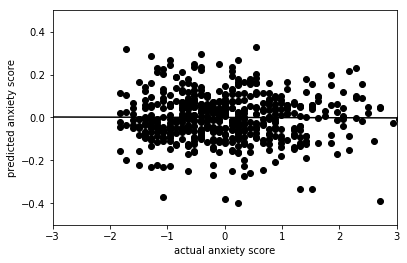

In [22]:
# STAI alone
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
('impute',Imputer(missing_values='NaN',strategy='mean')),#only relevant for  amyg_data
('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)

r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z],stai,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,stai))



plt.plot(stai,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(stai.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3]).reshape(-1,1))
plt.plot([-3,3],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.xlim([-3,3])
plt.ylim([-.5,.5])
fontsize=18
plt.rc('font',**{ 'size':fontsize})
plt.tight_layout()




 r squared:
0.02746909063196812
correlation between actual and predicted anxiety:
(0.16588041200581638, 0.00012299298951210587)


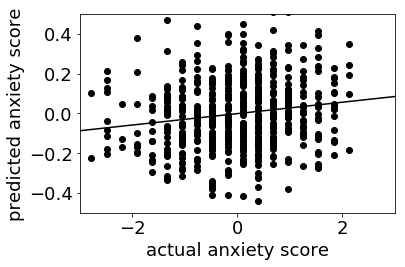

In [23]:
# BIS
r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z],bis,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,bis))



plt.plot(bis,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(bis.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3]).reshape(-1,1))
plt.plot([-3,3],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.xlim([-3,3])
plt.ylim([-.5,.5])
fontsize=18
plt.rc('font',**{ 'size':fontsize})
plt.tight_layout()

 r squared:
0.03269149615910927
correlation between actual and predicted anxiety:
(0.18087118123947363, 2.756532080104815e-05)


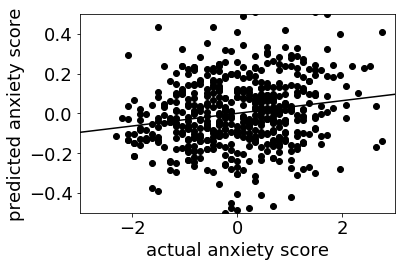

In [24]:
# NEO

r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z],neo,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,neo))



plt.plot(neo,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(neo.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3]).reshape(-1,1))
plt.plot([-3,3],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.xlim([-3,3])
plt.ylim([-.5,.5])
fontsize=18
plt.rc('font',**{ 'size':fontsize})
plt.tight_layout()




 r squared:
0.0358780674126028
correlation between actual and predicted anxiety:
(0.19439621241053642, 6.418441480570951e-06)


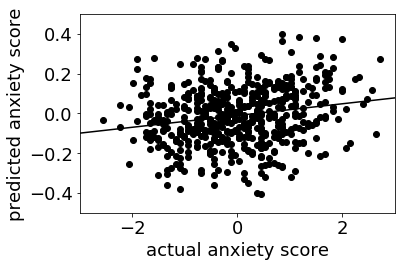

In [25]:
# TCI

r2,preds = stack([graph_data,aseg_aparc_data,amyg_data_z],tci,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,tci))



plt.plot(tci,preds,'o',color='black')
linreg = LinearRegression() #get regression line for plot

linreg.fit(tci.reshape(-1, 1),preds)
line = linreg.predict(np.array([-3,3]).reshape(-1,1))
plt.plot([-3,3],line,color='black')
plt.xlabel('actual anxiety score')
plt.ylabel('predicted anxiety score')
plt.xlim([-3,3])
plt.ylim([-.5,.5])
fontsize=18
plt.rc('font',**{ 'size':fontsize})
plt.tight_layout()




### extract feature weights, assign p values

In [35]:
def stack_weights(Xs,y,inner_pipeline,outer_pipeline):
    #gets weights on  features for stacking model.
    #does not make predictions on test observations--just for understanding the model.
    #Args:
        #Xs is a list containing the different datasets. elements should have the same # observations
        #y: outcome variable
        #inner pipeline: pipeline containing inner (base) model
        #outer_pipeline: pipeline containing outer (stacking) model
    #Output:
        #betas_outer: weights of the meta features, length m (where m = # of base models)
        #betas_inner: average weights of the base model features, list of length m containing np arrays
            #of length (num features in base model)
        #betas_total: total weight of the original input features, list of length m containing np arrays
            #of length (num features in base model) 
            #(calculation: outer beta corresponding to a base model * all the inner betas for that model)
    

    num_models = len(Xs)
    stack_split = cv_stratified(num_models,y)#split into folds for model stacking

    meta_feat_train = np.zeros((len(y),num_models))
    betas_inner = []
    for m in np.arange(num_models): #have to run each model
        X = Xs[m]#select the relevant x dataset
        betas_inner.append([])
        betas_inner[m] = np.zeros((num_models,X.shape[1]))
        for f in np.arange(num_models): #have to run each model in each inner fold of stacking .
            X_train = X[stack_split[f][0]] # training examples for stacking
            X_test = X[stack_split[f][1]]

            y_train = y[stack_split[f][0]] 
            y_test = y[stack_split[f][1]]

            #fit inner model
            inner_pipeline.fit(X_train, y_train)

            #record predictions for train and test (meta features)
            meta_feat_train[stack_split[f][1],m] = inner_pipeline.predict(X_test).ravel()
            betas_inner[m][f] = inner_pipeline.named_steps['regression'].coef_
        betas_inner[m] = np.mean(betas_inner[m],0)
    #train outer (stacked) model on training meta features
    outer_pipeline.fit(meta_feat_train,y=y)
    [betas_outer] = outer_pipeline.named_steps['regression'].coef_
    betas_total = []
    for m in np.arange(num_models):
        betas_total.append(betas_outer[m]*betas_inner[m])

    return(betas_outer,betas_inner,betas_total)




In [36]:
#linear regression outer (stacking) model
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
('impute',Imputer(missing_values='NaN',strategy='mean')),#only relevant for  amyg_data
('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)

betas_outer_true,betas_inner_true,betas_total_true = stack_weights([graph_data,aseg_aparc_data,amyg_data_z],anx_data,inner_pipeline,linreg_pipeline)

print(betas_outer_true)
np.savetxt(output_data_folder + 'discovery/betas_stack.csv',betas_outer_true,delimiter=',')


[0.16442215 0.08370337 0.05894404]


In [51]:
#get p vals through permutation testing

random.seed(44)
num_it = 5000 #number iterations
betas_outer_perm = np.zeros((num_it,3))

betas_total_perm = [np.zeros((num_it,graph_data.shape[1])),np.zeros((num_it,aseg_aparc_data.shape[1])),
              np.zeros((num_it,amyg_data_z.shape[1]))]
perm = np.arange(len(anx_data))
for i in range(num_it):
    random.shuffle(perm)
    anx_data_perm = anx_data[perm] 
    betas_outer,betas_inner,betas_total = stack_weights([graph_data,aseg_aparc_data,amyg_data_z],anx_data_perm
                                                 ,inner_pipeline,linreg_pipeline)
    betas_outer_perm[i] = betas_outer
    betas_total_perm[0][i] = betas_total[0]
    betas_total_perm[1][i] = betas_total[1]
    betas_total_perm[2][i] = betas_total[2]

    if np.mod(i,500)==0:
        print(i)






0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [72]:
#get the p values for "total" betas
ps = [np.zeros(betas_total_true[0].shape),np.zeros(betas_total_true[1].shape),np.zeros(betas_total_true[2].shape)]
for i in range(3):
    ps[i][betas_total_true[i]>=0] =2*np.sum(betas_total_perm[i][:,betas_total_true[i]>=0] >=
                                           betas_total_true[i][betas_total_true[i]>=0],axis=0)/num_it
    ps[i][betas_total_true[i]<0] =2*np.sum(betas_total_perm[i][:,betas_total_true[i]<0] <
                                          betas_total_true[i][betas_total_true[i]<0],axis=0)/num_it
    print('model ' + str(i) + ' : number of significant total betas, p<.001')
    print(len(np.where(ps[i]<=.001)[0]))

ps_outer =2*np.sum(betas_outer_perm >=betas_outer_true,axis=0)/num_it

print('outer betas and p-values')
print(betas_outer_true)
print(ps_outer)

np.savetxt(output_data_folder + 'discovery/betas_graph.csv',betas_total_true[0],delimiter=',')
np.savetxt(output_data_folder + 'discovery/betas_struct.csv',betas_total_true[1],delimiter=',')
np.savetxt(output_data_folder + 'discovery/betas_amyg.csv',betas_total_true[2],delimiter=',')

np.savetxt(output_data_folder + 'discovery/ps_graph.csv',ps[0],delimiter=',')
np.savetxt(output_data_folder + 'discovery/ps_struct.csv',ps[1],delimiter=',')
np.savetxt(output_data_folder + 'discovery/ps_amyg.csv',ps[2],delimiter=',')
np.savetxt(output_data_folder + 'discovery/1-ps_amyg.csv',1-ps[2],delimiter=',')

model 0 : number of significant total betas, p<.001
353
model 1 : number of significant total betas, p<.001
0
model 2 : number of significant total betas, p<.001
1
outer betas and p-values
[0.16442215 0.08370337 0.05894404]
[0.0012 0.0792 0.2516]


### censoring

In [13]:
#load censored data
amyg_data_z = []
amyg_data_c = pd.read_csv(input_data_folder + 'discovery/censor/Amygdala.csv',header=None).values
amyg_naned = np.array(amyg_data_c)

nan_idx = coverage_data==0
amyg_naned[nan_idx] = np.nan

#zscoring
amyg_data_z_c = np.array(amyg_naned)
for i in range(amyg_data_z_c.shape[0]):
    amyg_data_z_c[i,~np.isnan(amyg_naned[i,:])]= stats.zscore(amyg_data_z_c[i,~np.isnan(amyg_naned[i,:])])



graph_data_c = pd.read_csv(input_data_folder + 'discovery/censor/fsDiscCens.csv',header=None)
graph_data_c = np.transpose(graph_data_c.values)


In [14]:
#linear regression outer (stacking) model
linreg_pipeline_steps = [
 ('standardize', StandardScaler()), 
('regression', LinearRegression())
]
linreg_pipeline = Pipeline(linreg_pipeline_steps)

inner_pipeline_steps = [
('impute',Imputer(missing_values='NaN',strategy='mean')),#only relevant for  amyg_data
('standardize', StandardScaler()), 
('regression', Ridge(1000))
]
inner_pipeline = Pipeline(inner_pipeline_steps)



r2,preds = stack([graph_data_c,aseg_aparc_data,amyg_data_z_c],anx_data,inner_pipeline,linreg_pipeline)
print(' r squared:')
print(r2)

print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data))




 r squared:
0.03259876884197521
correlation between actual and predicted anxiety:
(array([0.18663546]), array([1.50006538e-05]))


0.0020000000000000018


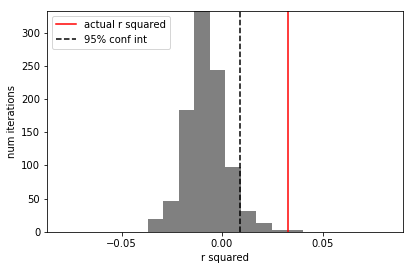

In [15]:
null_scores,p,actual_score = stack_perm([graph_data_c,aseg_aparc_data,amyg_data_z_c],
                                        anx_data,inner_pipeline,linreg_pipeline,1000,
                                        figname=output_data_folder + 'discovery/stack_perm_c.png')
np.savetxt(output_data_folder + 'discovery/null_r2_disc_c.csv',null_scores,delimiter=',')

print(p)



### CPM with shen

In [16]:
#shen segmentation
#load data
graph_data_file = input_data_folder + 'discovery/shenDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)

In [17]:
#cpm
r2_pos,r2_neg,preds_pos,preds_neg = cpm_cv(graph_data,anx_data)
print('CPM-shen')
print(' r squared for positive model:')
print(r2_pos)
print(' r squared for negative model:')
print(r2_neg)

print('corr between actual and predicted anxiety for positive model:')
print(stats.pearsonr(preds_pos,anx_data))
print('corr between actual and predicted anxiety for negative model:')
print(stats.pearsonr(preds_neg,anx_data))




CPM-shen
 r squared for positive model:
-0.1662787332580209
 r squared for negative model:
-0.16464575806773807
corr between actual and predicted anxiety for positive model:
(array([0.05458202]), array([0.20921406]))
corr between actual and predicted anxiety for negative model:
(array([0.059216]), array([0.17303375]))


### rvr with power

In [13]:
#load data
graph_data_file = input_data_folder + 'discovery/powerDisc.csv' 
graph_data = pd.read_csv(graph_data_file,header=None)
graph_data = np.transpose(graph_data.values)
compos_anx_file = input_data_folder + 'discovery/composAnxPowerDisc.csv'
anx_data = pd.read_csv(compos_anx_file, header=None)
anx_data = anx_data.values

In [14]:
steps = [
    ('standardize', StandardScaler()), 
    ('regression', RVR(kernel = 'rbf'))
]
pipeline = Pipeline(steps)


n_folds = 6
cv = cv_stratified(n_folds,anx_data.ravel())

preds = np.zeros(np.shape(anx_data.ravel()))

for train, test in cv:

    pipeline.fit(graph_data[train], anx_data.ravel()[train])
    preds[test] = pipeline.predict(graph_data[test])
r2 = r2_score(anx_data.ravel(),preds)
        
print('Ridge regression:')
print('r squared:')
print(r2)
print('correlation between actual and predicted anxiety:')
print(stats.pearsonr(preds,anx_data.ravel()))


Ridge regression:
r squared:
-0.0005822797838281879
correlation between actual and predicted anxiety:
(0.08750003043061266, 0.04406109854454535)
